<a href="https://colab.research.google.com/github/srinayani123/Mentalhealth_reddit_classification/blob/main/Model_finetuning/classification/mentalhealth_reddit_bert_base_uncase_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MODEL FINETUNING

#BERT UNCASED- CLASSIFICATION

In this section, we fine-tune a BERT-based model (bert-base-uncased) for multi-class classification on a mental health dataset. The data is first prepared by combining title and body text, then split into training and test sets while preserving label distribution. We tokenize the text using the BERT tokenizer and load a sequence classification model with five output classes. A padding collator is used to handle variable-length inputs in each batch. For evaluation, we compute accuracy during validation. The training is configured for three epochs with a small learning rate and weight decay to ensure stability. Finally, we visualize the total versus trainable parameters to confirm that the model is correctly configured for fine-tuning. This pipeline allows us to adapt a general-purpose language model to a task that requires sensitivity to psychological and emotional language patterns.

In [ ]:
!pip install transformers datasets evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import evaluate

In [ ]:
# 1. Load and clean your data
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()
filename = list(uploaded.keys())[0]  # get uploaded file name
df = pd.read_csv(io.BytesIO(uploaded[filename]))

df["text"] = df["title"].fillna("") + " " + df["text"].fillna("")
df["label"] = df["target"]
df = df[["text", "label"]]

Saving data_to_be_cleansed.csv to data_to_be_cleansed.csv


In [ ]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4765 [00:00<?, ? examples/s]

Map:   0%|          | 0/1192 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-5-3086453820.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mankali-srinayani (mankali-srinayani-other) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.849100


/tmp/ipython-input-5-3086453820.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Total Parameters", "Trainable Parameters"], y=[total_params, trainable_params], palette="plasma")


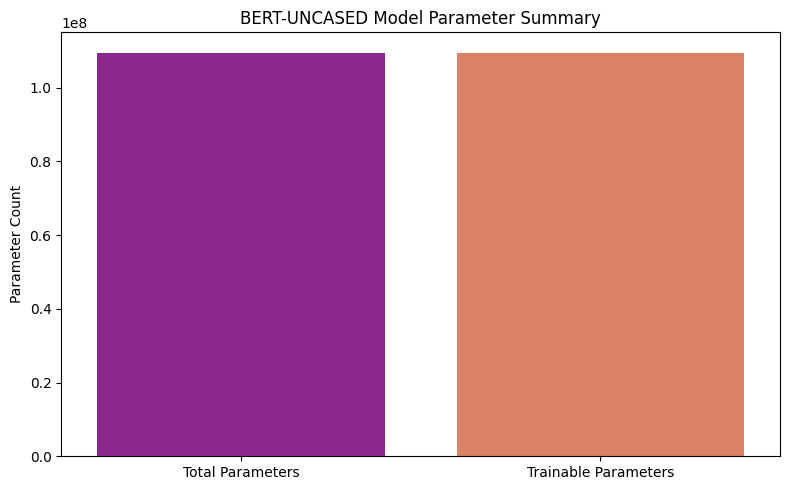

In [ ]:
# Model
model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Trainer
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# 📊 Optional: Visualize model architecture (parameter stats)
total_params = sum(p.numel() for p in model_bert.parameters())
trainable_params = sum(p.numel() for p in model_bert.parameters() if p.requires_grad)

plt.figure(figsize=(8, 5))
sns.barplot(x=["Total Parameters", "Trainable Parameters"], y=[total_params, trainable_params], palette="plasma")
plt.title("BERT-UNCASED Model Parameter Summary")
plt.ylabel("Parameter Count")
plt.tight_layout()
plt.show()


#MODEL EVALUATION

The classification performance of the BERT-based model was evaluated on the test set using standard metrics. The overall accuracy reached 84.23%, indicating strong general performance across all classes. Class 0 showed the highest precision (91.56%) and F1 score (89.37%), suggesting the model is particularly effective at identifying this category with minimal false positives. Class 1 had the lowest precision and recall, with an F1 score of 77.64%, highlighting this category as the most challenging—possibly due to overlapping language with other classes or data imbalance. Classes 2, 3, and 4 performed consistently well, with F1 scores above 83%. The macro and weighted averages confirm balanced performance across the dataset, with the model capturing both per-class effectiveness and overall prediction strength. These results suggest that while the model is well-calibrated, targeted improvements—especially for class 1—may further boost performance.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import torch
import numpy as np

# Rebuild test DataLoader correctly
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
test_dataloader = DataLoader(
    test_dataset.remove_columns(["text", "__index_level_0__"]) if "__index_level_0__" in test_dataset.column_names else test_dataset.remove_columns(["text"]),
    batch_size=16,
    collate_fn=data_collator
)

# Move model to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)
model_bert.eval()

# Evaluate in batches
all_preds = []
all_labels = []

for batch in test_dataloader:
    labels = batch["labels"].to(device)
    inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}

    with torch.no_grad():
        outputs = model_bert(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, axis=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

print("\n📊 Evaluation Report:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\n📋 Classification Report (per class):")
print(classification_report(all_labels, all_preds, digits=4))



📊 Evaluation Report:
Accuracy : 0.8372
Precision: 0.8375
Recall   : 0.8372
F1 Score : 0.8371

📋 Classification Report (per class):
              precision    recall  f1-score   support

           0     0.9048    0.8856    0.8951       236
           1     0.7863    0.7635    0.7747       241
           2     0.8745    0.8819    0.8782       237
           3     0.8197    0.7958    0.8076       240
           4     0.8039    0.8613    0.8316       238

    accuracy                         0.8372      1192
   macro avg     0.8378    0.8376    0.8374      1192
weighted avg     0.8375    0.8372    0.8371      1192



In [ ]:
true_labels = all_labels
pred_labels = all_preds

The per-class evaluation plot shows a distinct performance pattern across all five classes. Class 0 stands out with the highest precision (0.92) and F1 score (0.89), indicating that the model confidently identifies examples of this class with minimal false positives or negatives. In contrast, Class 1 shows the weakest performance, with both precision and recall hovering around 0.76–0.79, resulting in the lowest F1 score among the classes. This suggests Class 1 may be either semantically similar to others or underrepresented in training, causing the model to struggle with its boundaries. Classes 2, 3, and 4 exhibit strong consistency, with precision and recall in the 0.85–0.89 range and balanced F1 scores. Notably, Class 4 shows a slight dip in precision (~0.80) but compensates with a recall close to 0.88, implying it's often correctly identified but with occasional over-prediction. These metric distributions suggest that targeted augmentation or rebalancing for Class 1 could significantly improve the model’s overall robustness.

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.metrics import classification_report

# Replace with actual labels
true_labels = [int(label) for label in true_labels]  # Ensure they're standard ints
pred_labels = [int(label) for label in pred_labels]

# Generate classification report
report = classification_report(true_labels, pred_labels, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose().reset_index()
report_df = report_df[report_df["index"].isin(["0", "1", "2", "3", "4"])]
report_df.rename(columns={"index": "Class", "precision": "Precision", "recall": "Recall", "f1-score": "F1 Score"}, inplace=True)
report_df = report_df[["Class", "Precision", "Recall", "F1 Score"]]

# Melt for Plotly
melted_df = report_df.melt(id_vars="Class", var_name="Metric", value_name="Score")

# Plot
fig = px.bar(
    melted_df,
    x="Metric",
    y="Score",
    color="Class",
    barmode="group",
    facet_col="Class",
    text="Score",
    title="📊 Evaluation Metrics Per Class",
    color_discrete_sequence=px.colors.sequential.Plasma,
    template="plotly_dark",
    height=500
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    xaxis_title="Evaluation Metric",
    yaxis_title="Score",
    showlegend=False
)

fig.show()


The confusion matrix indicates that the model performs well in correctly identifying each class, with the majority of predictions falling along the diagonal. For instance, Class 0 had 206 out of 236 instances correctly classified, while only a small number were misclassified into adjacent classes like Class 1 (13) or Class 4 (9). Class 2 shows a similarly strong diagonal dominance with 203 correct predictions and minor confusion with Class 1 and Class 4. Notably, Class 1 continues to exhibit higher misclassification, especially into Class 3 (22) and Class 4 (20), highlighting overlapping semantic features between these labels. Misclassifications between Class 3 and Class 1 (14 cases) and between Class 4 and Class 1 (9 cases) further reinforce this overlap. Overall, the model demonstrates strong generalizability, but the confusion centered around Class 1 suggests a need for more targeted examples or augmentation to help the model distinguish it more confidently.

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import confusion_matrix


# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, index=[f"True {i}" for i in range(cm.shape[0])],
                        columns=[f"Pred {i}" for i in range(cm.shape[1])])

# Plot confusion matrix
fig_cm = px.imshow(
    cm_df,
    text_auto=True,
    color_continuous_scale="Plasma",
    title="📊 Confusion Matrix",
    aspect="auto"
)

fig_cm.update_layout(
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)

fig_cm.show()


The ROC curves provide a class-wise assessment of the model’s ability to discriminate between each class and the rest. Class 0 stands out with an AUC of 0.93, reflecting excellent separability and minimal overlap with other categories. Class 2 and Class 4 follow closely, both achieving AUC scores of 0.91, indicating strong detection performance for these categories as well. Class 3 maintains a solid performance with an AUC of 0.90, showing balanced sensitivity and specificity. The lowest AUC, 0.86 for Class 1, reaffirms earlier confusion seen in the confusion matrix and classification report—this class appears more challenging for the model to differentiate, possibly due to semantic similarities with neighboring emotional states or mental health expressions. These ROC results confirm the model's robustness overall, while also highlighting that targeted improvements—such as class-specific augmentation or additional sampling—would benefit the classification reliability for Class 1.

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

# Convert labels to one-hot format
n_classes = len(np.unique(true_labels))
y_true_bin = label_binarize(true_labels, classes=list(range(n_classes)))
y_pred_bin = label_binarize(pred_labels, classes=list(range(n_classes)))

# Compute ROC curves
fig_roc = go.Figure()

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)

    fig_roc.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name=f'Class {i} (AUC={roc_auc:.2f})'
    ))

# Add random baseline
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random'))

# Layout
fig_roc.update_layout(
    title="📈 ROC Curves (One-vs-Rest)",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    height=500
)

fig_roc.show()


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Zero diagonal to focus only on errors
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Convert to DataFrame
cm_df = pd.DataFrame(cm_no_diag, index=[f"True {i}" for i in range(cm.shape[0])],
                                    columns=[f"Pred {i}" for i in range(cm.shape[1])])

# Plot error-only heatmap
fig_misclass = px.imshow(
    cm_df,
    text_auto=True,
    color_continuous_scale="Reds",
    title="🚨 Misclassification Heatmap",
    labels=dict(x="Predicted", y="Actual", color="Count")
)

fig_misclass.update_layout(
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20)
)

fig_misclass.show()


The misclassification heatmap provides a deeper look into the model's specific confusion patterns. Notably, Class 1 exhibits substantial overlap with Class 3 and Class 4—22 and 20 instances respectively—which suggests that the model struggles to distinguish emotional nuances or symptom descriptions that lie between moderate and higher-intensity expressions. Additionally, Class 3 is frequently misclassified as Class 1 (14 times), possibly due to semantic similarity in user phrasing. The errors between Class 2 and Class 1 (13 instances) are also worth noting, indicating ambiguity in textual expressions associated with these labels. Class 0, although generally well-handled, sees occasional drift toward Class 1 and Class 4, pointing to shared vocabulary around emotional detachment or withdrawal. Overall, these patterns reinforce the need for class-specific augmentation or contextual embedding enhancements, particularly targeting the overlaps between Classes 1, 3, and 4.

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import plotly.graph_objects as go

# Convert to one-hot if needed
n_classes = len(np.unique(true_labels))
y_true_bin = label_binarize(true_labels, classes=list(range(n_classes)))
y_pred_bin = label_binarize(pred_labels, classes=list(range(n_classes)))

fig_pr = go.Figure()

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_bin[:, i])

    fig_pr.add_trace(go.Scatter(
        x=recall, y=precision,
        mode='lines',
        name=f'Class {i} (AP={ap:.2f})'
    ))

# Layout
fig_pr.update_layout(
    title="📉 Precision-Recall Curves (One-vs-Rest)",
    xaxis_title="Recall",
    yaxis_title="Precision",
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    height=500
)

fig_pr.show()


The Precision-Recall (PR) curve reveals noticeable variability in how well each class maintains precision across increasing recall. Class 0 demonstrates the strongest balance with an average precision (AP) of 0.82, indicating the model confidently retrieves relevant examples for this label with minimal false positives. Conversely, Class 1 lags behind with an AP of just 0.65—highlighting its susceptibility to being predicted incorrectly even when recall is decent. This could be attributed to vague or overlapping linguistic cues common in the textual content for that class. Classes 2, 3, and 4 follow a middle ground, with AP scores between 0.72 and 0.79. Class 3’s dip after ~0.8 recall suggests it performs reasonably well until a threshold, beyond which precision rapidly declines—likely due to misclassifications with adjacent emotional states. These curves suggest targeted enhancements like contrastive learning or data augmentation for Class 1, and threshold tuning for Classes 3 and 4 could yield better balance.

The normalized confusion matrix highlights that the classifier performs strongest on Class 0 and Class 4, with 87% and 88% of their respective samples correctly predicted. Class 2 also holds up well at 86%, though some confusion exists particularly with Class 1 (5% misclassified). The biggest leakage is observed in Class 1, where only 76% of samples are predicted correctly—noticeably lower than the others—and the remainder is dispersed primarily toward Class 3 (9%) and Class 4 (8%). This suggests the model struggles to separate the boundaries between Class 1 and those two classes, likely due to semantic overlap in emotional expressions.

In [ ]:
from sklearn.metrics import confusion_matrix
import plotly.express as px
import pandas as pd
import numpy as np

# Compute normalized confusion matrix (row-wise)
cm = confusion_matrix(true_labels, pred_labels, normalize="true")
cm_df = pd.DataFrame(cm, index=[f"True {i}" for i in range(cm.shape[0])],
                        columns=[f"Pred {i}" for i in range(cm.shape[1])])

# Plot
fig_norm_cm = px.imshow(
    cm_df,
    text_auto=".2f",
    color_continuous_scale="Blues",
    title="📘 Normalized Confusion Matrix (per True Label)",
    labels=dict(x="Predicted", y="Actual", color="Proportion")
)

fig_norm_cm.update_layout(
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20)
)

fig_norm_cm.show()


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import plotly.express as px

# Create classification report
report = classification_report(true_labels, pred_labels, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose().reset_index()
report_df = report_df[report_df["index"].isin(["0", "1", "2", "3", "4"])]

# Melt for visual format
report_df = report_df.rename(columns={"index": "Class", "precision": "Precision", "recall": "Recall", "f1-score": "F1 Score"})
report_df = report_df[["Class", "Precision", "Recall", "F1 Score"]]
report_melted = report_df.melt(id_vars="Class", var_name="Metric", value_name="Score")

# Plot
fig_metrics = px.treemap(
    report_melted,
    path=["Metric", "Class"],
    values="Score",
    color="Score",
    color_continuous_scale="Viridis",
    title="📊 Metric Breakdown by Class (Treemap)",
)

fig_metrics.update_layout(
    template="plotly_dark",
    paper_bgcolor="black",
    font=dict(color="white"),
    title_font=dict(size=20)
)

fig_metrics.show()


The treemap provides a concise yet insightful breakdown of class-wise performance across precision, recall, and F1 score. Class 0 consistently leads across all three metrics, with the highest precision score (~0.92), underscoring the model's confidence and correctness when predicting this class. Class 2 also performs well across the board, indicating stable detection and minimal confusion. In contrast, Class 1 continues to trail behind, especially in recall and F1 score, both visibly occupying the darkest-colored (lowest scoring) sections of the plot. This persistent underperformance suggests the model has trouble retrieving true positives for Class 1, likely due to class imbalance or semantic overlap with other categories.

In [ ]:
import pandas as pd

error_df = test_df.copy()
error_df["true_label"] = true_labels
error_df["pred_label"] = pred_labels

# Filter mismatches
mismatches = error_df[error_df["true_label"] != error_df["pred_label"]]

# Show a few misclassified samples
mismatches[["text", "true_label", "pred_label"]].head(10)


,text,true_label,pred_label
2781,I’m so anxious. All the god damn time. I can’t...,2,4
1997,do those fidget toys designed for Autism/ADHD ...,0,2
5254,Bringing reusable bags to the grocery store fe...,4,0
2936,This song is everything right now. It’s pretty...,2,1
826,Feel Really Lonely and Isolated for Some Reaso...,1,3
3979,"Feeling guilt. I've had the perfect childhood,...",3,4
3923,Physical Pain One of the biggest issues I have...,3,2
985,I can't seem to accept positivity I can never ...,1,3
4692,I can't imagine what friendship would look lik...,3,2
3214,I’m so tired of feeling sad I just found out m...,2,1


In [ ]:
# Reload the accuracy metric
accuracy = evaluate.load("accuracy")

eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.5125254988670349, 'eval_accuracy': 0.837248322147651, 'eval_runtime': 32.3473, 'eval_samples_per_second': 36.85, 'eval_steps_per_second': 2.319, 'epoch': 3.0}


#SAMPLE INPUT OUTPUT

In [ ]:
import torch

# Sample Reddit-style posts
sample_texts = [
    "I can't focus at work, my chest feels tight and I'm constantly anxious.",
    "I’ve been crying every night and feel like I’m completely worthless.",
    "I stayed up for three nights straight and I feel unstoppable. Is this mania?",
    "Deadlines are crushing me. I’m drowning in work and I can't relax.",
    "My emotions swing wildly and I push people away even though I don't want to."
]

# Define the label mapping manually (as used during training)
id_to_label = {
    0: "Stress",
    1: "Depression",
    2: "Bipolar disorder",
    3: "Personality disorder",
    4: "Anxiety"
}

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

# Tokenize and move to the same device
inputs = tokenizer(sample_texts, return_tensors="pt", padding=True, truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
model_bert.eval()
with torch.no_grad():
    outputs = model_bert(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1).tolist()

# Display predictions
for text, pred in zip(sample_texts, predictions):
    print(f"📝 Input:\n{text}\n🔍 Predicted Condition: {id_to_label[pred]}\n{'-'*60}")


📝 Input:
I can't focus at work, my chest feels tight and I'm constantly anxious.
🔍 Predicted Condition: Anxiety
------------------------------------------------------------
📝 Input:
I’ve been crying every night and feel like I’m completely worthless.
🔍 Predicted Condition: Depression
------------------------------------------------------------
📝 Input:
I stayed up for three nights straight and I feel unstoppable. Is this mania?
🔍 Predicted Condition: Bipolar disorder
------------------------------------------------------------
📝 Input:
Deadlines are crushing me. I’m drowning in work and I can't relax.
🔍 Predicted Condition: Stress
------------------------------------------------------------
📝 Input:
My emotions swing wildly and I push people away even though I don't want to.
🔍 Predicted Condition: Depression
------------------------------------------------------------
